In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold

from concepts import concept_instances
from utils import load_game_data, prepare_folders, load_q_network_device

In [3]:
q_network, device = load_q_network_device()
game_data = load_game_data()
concept = concept_instances['ball right paddle (b)']
concept.prepare_data(data, max_size=5000)

In [4]:
class ProbeNetwork(nn.Module):
    def __init__(self, q_network, layer_index, input_dim, binary):
        super().__init__()
        self.binary = binary
        # Clone the original network up to layer
        self.features = nn.Sequential(*[layer for layer in q_network.network.children()][:layer_index])
        
        # Freeze the parameters of the original network
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Add the new layer
        if binary:
            self.probe = nn.Sequential(nn.Linear(input_dim, 1), nn.Sigmoid())
        else:
            self.probe = nn.Sequential(nn.Linear(input_dim, 1))

    def forward_features(self, x):
        x = x / 255.0
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

    def forward_probe(self, x):
        x = self.probe(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_probe(x)
        return x

    def _get_accuracy(self, x, y):
        y_pred = self.forward(x)
        y_pred = (y_pred > 0.5).float()
        correct = (y_pred == y).float().sum()
        accuracy = correct / y.size(0)
        return accuracy

    def _get_r2(self, x, y):
        y_pred = self.forward(x)
        total_variance = torch.var(y, unbiased=False)
        residual_variance = F.mse_loss(y_pred, y, reduction='sum')
        r2 = 1 - (residual_variance / (total_variance * y.size(0)))
        return r2
        
    def get_score(self, x, y):
        if self.binary:
            score = 2 * self._get_accuracy(x, y) - 1
        else:
            score = self._get_r2(x, y)
        return round(max(0.0, score.item()), 4)

In [5]:
train_obs = torch.tensor(concept.train_obs).float().to(device)
test_obs = torch.tensor(concept.test_obs).float().to(device)
train_values = torch.tensor(concept.train_values).float().to(device).unsqueeze(1)
test_values = torch.tensor(concept.test_values).float().to(device).unsqueeze(1)

In [6]:
layer_index = 8
input_dim = 512
binary = True
loss_fn = nn.MSELoss()
l1_lambda = 0.001
learning_rate = 0.001
epochs = 1000
probe_network = ProbeNetwork(q_network, layer_index, input_dim, binary).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, probe_network.parameters()), lr=learning_rate)

## Train concept probe

In [7]:
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = probe_network(train_obs)
    train_loss = loss_fn(outputs, train_values)
    l1_reg = torch.tensor(0.0, device=device)
    for param in filter(lambda p: p.requires_grad, probe_network.parameters()):
        l1_reg += torch.norm(param, p=1)
    train_loss += l1_lambda * l1_reg
    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        outputs = probe_network(test_obs)
        print(f"Test score: {probe_network.get_score(test_obs, test_values)}")

Test score: 0.012
Test score: 0.652
Test score: 0.706
Test score: 0.718
Test score: 0.736
Test score: 0.754
Test score: 0.756
Test score: 0.756
Test score: 0.76
Test score: 0.762


torch.Size([1, 4, 84, 84])
Concept value: 1
Target concept value: 0


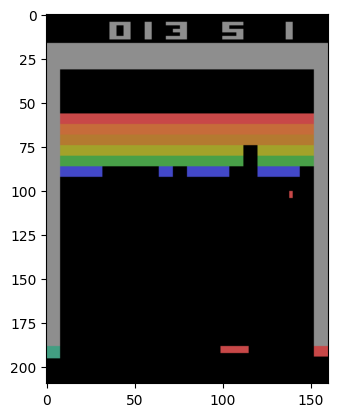

In [48]:
ex_idx = 1
example_obs = concept.test_obs[ex_idx]
example_obs = torch.from_numpy(example_obs).unsqueeze(0).to(device).float()
print(example_obs.shape)
print(f"Concept value: {concept.test_values[ex_idx]}")
if concept.test_values[ex_idx] == 1:
    target_concept_value = 0
else:
    target_concept_value = 1
print(f"Target concept value: {target_concept_value}")
plt.imshow(concept.test_images[ex_idx])
plt.show()

# Direct concept backprop

In [261]:
pertubation_lr = 0.01
iterations = 100
loss_ratio = 1

activation = nn.Hardtanh(min_val=0, max_val=255.0)

# Initialize perturbation with small value
small_noise = torch.ones_like(example_obs) * 0.001
perturbation = small_noise.clone().detach().requires_grad_(True)
initial_prediction = probe_network(activation(example_obs + perturbation * 255.0))
print(f"Initial Prediction: {initial_prediction.item()}")

for i in range(iterations):
    # calculate how wrong the concept value is
    perturbed_obs = activation(example_obs + perturbation * 255.0)
    concept_value_pred = probe_network(perturbed_obs)
    loss1 = torch.norm(concept_value_pred - target_concept_value, p=1)
    loss2 = torch.norm(perturbation, p=2)
    total_loss = loss_ratio * loss1 + loss2
    if i % 10 == 0 or i == iterations - 1:
        print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    total_loss.backward()

    # update perturbation
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()
        
perturbed_obs = activation(example_obs + perturbation * 255.0)
final_prediction = probe_network(perturbed_obs)
print(f"Final Prediction: {final_prediction.item()}")

Initial Prediction: 0.8602234125137329
Iteration   0 - Loss1: 0.8602, Loss2: 0.1680, Total Loss: 1.0282
Iteration  10 - Loss1: 0.0350, Loss2: 0.2153, Total Loss: 0.2503
Iteration  20 - Loss1: 0.0251, Loss2: 0.1875, Total Loss: 0.2126
Iteration  30 - Loss1: 0.0270, Loss2: 0.1690, Total Loss: 0.1960
Iteration  40 - Loss1: 0.0225, Loss2: 0.1623, Total Loss: 0.1847
Iteration  50 - Loss1: 0.0221, Loss2: 0.1567, Total Loss: 0.1788
Iteration  60 - Loss1: 0.0214, Loss2: 0.1546, Total Loss: 0.1760
Iteration  70 - Loss1: 0.0199, Loss2: 0.1531, Total Loss: 0.1730
Iteration  80 - Loss1: 0.0197, Loss2: 0.1509, Total Loss: 0.1707
Iteration  90 - Loss1: 0.0199, Loss2: 0.1501, Total Loss: 0.1700
Iteration  99 - Loss1: 0.0198, Loss2: 0.1500, Total Loss: 0.1698
Final Prediction: 0.019952451810240746


In [50]:
def display_obs(tensor_obs, title):
    image = np.concatenate(tensor_obs.reshape(4, 84, 84).detach().cpu().numpy(), axis=1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [264]:
perturbation.max() * 255.0, perturbation.min() * 255.0

(tensor(4.3643, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(-2.5970, device='cuda:0', grad_fn=<MulBackward0>))

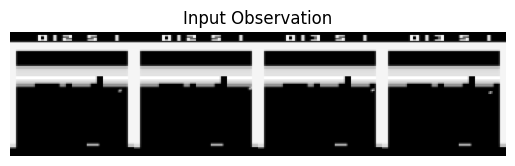

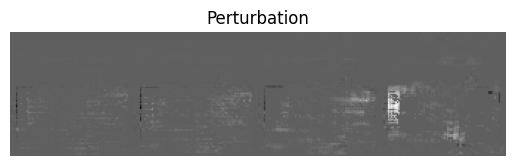

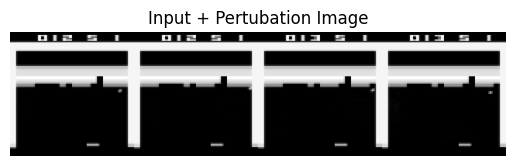

In [262]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Image')

# Concept backprop distance = difference mean pixel

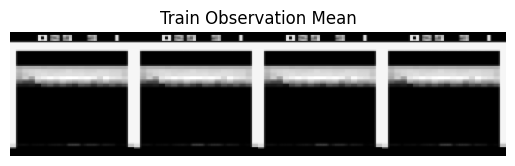

In [52]:
train_obs_means = concept.train_obs.mean(axis=0)
train_obs_means = torch.from_numpy(train_obs_means).unsqueeze(0).to(device).float()
display_obs(train_obs_means, 'Train Observation Mean')

In [232]:
pertubation_lr = 0.001
iterations = 1000
loss_ratio = 100

activation = nn.Hardtanh(min_val=0, max_val=255.0)

# Initialize perturbation with small value
small_noise = torch.ones_like(example_obs) * 0.001
perturbation = small_noise.clone().detach().requires_grad_(True)
initial_prediction = probe_network(activation(example_obs + perturbation * 255.0))
print(f"Initial Prediction: {initial_prediction.item()}")

for i in range(iterations):
    # calculate how wrong the concept value is
    perturbed_obs = activation(example_obs + perturbation * 255.0)
    concept_value_pred = probe_network(perturbed_obs)
    loss1 = torch.norm(concept_value_pred - target_concept_value, p=1)
    loss2 = torch.norm(perturbed_obs - train_obs_means, p=2)
    total_loss = loss_ratio * loss1 + loss2
    if i % 100 == 0 or i == iterations - 1:
        print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    total_loss.backward()

    # update perturbation
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()
        
perturbed_obs = activation(example_obs + perturbation * 255.0)
final_prediction = probe_network(perturbed_obs)
print(f"Final Prediction: {final_prediction.item()}")

Initial Prediction: 0.8602234125137329
Iteration   0 - Loss1: 0.8602, Loss2: 2240.6509, Total Loss: 2326.6733
Iteration 100 - Loss1: 0.0277, Loss2: 150.6707, Total Loss: 153.4385
Iteration 200 - Loss1: 0.0139, Loss2: 151.3528, Total Loss: 152.7441
Iteration 300 - Loss1: 0.0096, Loss2: 151.8099, Total Loss: 152.7650
Iteration 400 - Loss1: 0.0215, Loss2: 150.9141, Total Loss: 153.0624
Iteration 500 - Loss1: 0.0104, Loss2: 151.6501, Total Loss: 152.6889
Iteration 600 - Loss1: 0.0253, Loss2: 150.7616, Total Loss: 153.2872
Iteration 700 - Loss1: 0.0029, Loss2: 153.1576, Total Loss: 153.4495
Iteration 800 - Loss1: 0.0066, Loss2: 152.1555, Total Loss: 152.8144
Iteration 900 - Loss1: 0.0026, Loss2: 153.2562, Total Loss: 153.5143
Iteration 999 - Loss1: 0.0089, Loss2: 151.8746, Total Loss: 152.7646
Final Prediction: 0.014780636876821518


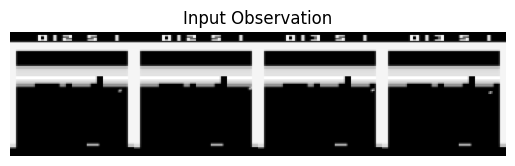

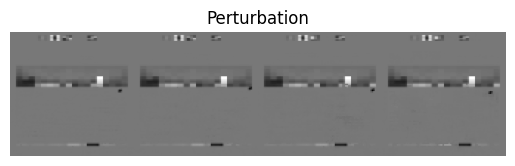

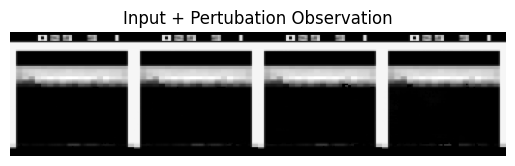

In [233]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Observation')

# Deep dream of highest Q-value (not concept related)

In [240]:
pertubation_lr = 0.001
iterations = 1000
loss_ratio = 0.5

activation = nn.Hardtanh(min_val=0, max_val=255.0)

# Initialize perturbation with small value
small_noise = torch.ones_like(example_obs) * 0.001
perturbation = small_noise.clone().detach().requires_grad_(True)
initial_prediction = q_network(activation(example_obs + perturbation * 255.0))
print(f"Initial Prediction: {initial_prediction}")

for i in range(iterations):
    perturbed_obs = torch.nn.functional.relu(activation(example_obs + perturbation * 255.0))
    
    q_values = q_network(perturbed_obs)
    
    loss1 = -torch.min(q_values)
    loss2 = torch.norm(perturbation, p=2)
    total_loss = loss_ratio * loss1 + loss2
    
    if i % 100 == 0:
        print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    
    total_loss.backward()
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()

perturbed_obs = torch.nn.functional.relu(activation(example_obs + perturbation * 255.0))
final_prediction = q_network(perturbed_obs)
print(f"Final Prediction: {final_prediction}")

Initial Prediction: tensor([[3.9394, 3.9424, 3.9156, 3.9295]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Iteration   0 - Loss1: -3.9156, Loss2: 0.1680, Total Loss: -1.7898
Iteration 100 - Loss1: -4.4068, Loss2: 0.1615, Total Loss: -2.0418
Iteration 200 - Loss1: -5.3115, Loss2: 0.2474, Total Loss: -2.4083
Iteration 300 - Loss1: -26.3559, Loss2: 0.7309, Total Loss: -12.4471
Iteration 400 - Loss1: -34.7435, Loss2: 1.1263, Total Loss: -16.2454
Iteration 500 - Loss1: -41.5474, Loss2: 1.4944, Total Loss: -19.2792
Iteration 600 - Loss1: -47.4032, Loss2: 1.8456, Total Loss: -21.8559
Iteration 700 - Loss1: -55.0831, Loss2: 2.2629, Total Loss: -25.2787
Iteration 800 - Loss1: -62.0965, Loss2: 2.6823, Total Loss: -28.3660
Iteration 900 - Loss1: -69.5450, Loss2: 3.1368, Total Loss: -31.6357
Final Prediction: tensor([[76.7097, 77.4225, 78.4650, 80.4427]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


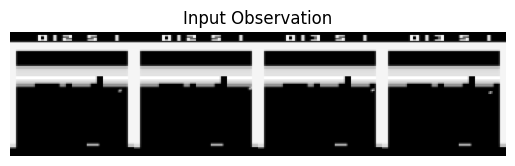

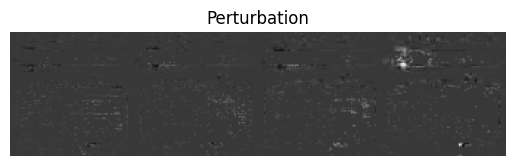

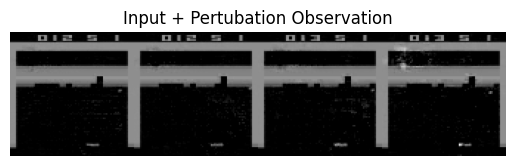

In [241]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Observation')

# Train autoencoder up until a layer

In [57]:
class Encoder(nn.Module):
    def __init__(self, latent_variables):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, latent_variables)  # projects down to 64 latent variables
        )

    def forward(self, x):
        x = x / 255.0  # Normalizing input
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_variables):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_variables, 512),  # Projection back to flattened size
            nn.ReLU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Unflattening the tensor
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid() # Using sigmoid activation to get values between 0 and 1
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x * 255.0  # Scaling back the output
        return x

# Autoencoder that combines Encoder and Decoder
class Autoencoder(nn.Module):
    def __init__(self, latent_variables):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_variables)
        self.decoder = Decoder(latent_variables)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [58]:
criterion = nn.MSELoss()

learning_rate = 0.005
num_epochs = 500
batch_size = 128
latent_dim = 64

autoencoder = Autoencoder(latent_dim).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i in range(0, len(train_obs), batch_size):
        batch = train_obs[i:i+batch_size]
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}: Loss: {loss.item()} | ', end='')
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(test_obs), batch_size):
                batch = test_obs[i:i+batch_size]
                outputs = autoencoder(batch)
                loss = criterion(outputs, batch)
                test_loss += loss.item()
            print(f'Validation Loss: {test_loss / (len(test_obs) // batch_size)}')

Epoch 0/500: Loss: 319.9962463378906 | Validation Loss: 433.2907496861049
Epoch 10/500: Loss: 102.04466247558594 | Validation Loss: 137.24272809709822
Epoch 20/500: Loss: 57.00830841064453 | Validation Loss: 80.94753592354911
Epoch 30/500: Loss: 35.801048278808594 | Validation Loss: 59.42103086199079
Epoch 40/500: Loss: 25.519533157348633 | Validation Loss: 40.85437992640904
Epoch 50/500: Loss: 19.165603637695312 | Validation Loss: 34.660464423043386
Epoch 60/500: Loss: 19.250736236572266 | Validation Loss: 32.751220703125
Epoch 70/500: Loss: 15.66407585144043 | Validation Loss: 28.858983721051896
Epoch 80/500: Loss: 14.05420207977295 | Validation Loss: 27.857861382620676
Epoch 90/500: Loss: 12.446938514709473 | Validation Loss: 25.60623904636928
Epoch 100/500: Loss: 11.597274780273438 | Validation Loss: 23.54543549673898
Epoch 110/500: Loss: 10.971287727355957 | Validation Loss: 23.653418949672155
Epoch 120/500: Loss: 10.516484260559082 | Validation Loss: 23.362457002912247
Epoch 130/

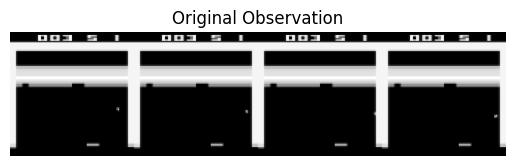

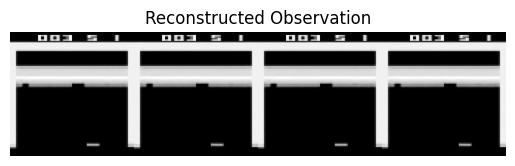

In [59]:
image = test_obs[0].unsqueeze(0)
reconstructed_image = autoencoder(image)
display_obs(image, 'Original Observation')
display_obs(reconstructed_image, 'Reconstructed Observation')

# Train decoder on probe

In [60]:
'''
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Linear(64 * 7 * 7, 4 * 84 * 84),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 4, 84, 84)
        return x * 255.0
'''

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7), # 512 hardcoded for layer in probe network
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)), # Matching the flattened dimension in the encoder
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x) * 255.0

decoder = Decoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

In [61]:
'''
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Shared layers (up to a certain point)
        self.shared_layers = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
        )

        # Image reconstruction branch
        self.image_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid()
        )

        self.scalar_layers = nn.Sequential(
            nn.Linear(12800, 100),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(100, 2)  # Output two scalar values
        )

    def forward(self, x):
        shared_output = self.shared_layers(x)
        
        # Flatten for scalar branch
        flat_output = shared_output.view(shared_output.size(0), -1)

        # Debug: Print the shape of flat_output
        print(f"Shape of flat_output: {flat_output.shape}")

        # Get image and scalar outputs
        img_output = self.image_layers(shared_output)
        scalar_output = self.scalar_layers(flat_output)

        return img_output * 255.0, scalar_output

decoder = Decoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)
'''

'\nclass Decoder(nn.Module):\n    def __init__(self):\n        super(Decoder, self).__init__()\n\n        # Shared layers (up to a certain point)\n        self.shared_layers = nn.Sequential(\n            nn.Linear(512, 64 * 7 * 7),\n            nn.ReLU(),\n            nn.Unflatten(1, (64, 7, 7)),\n            nn.ConvTranspose2d(64, 64, 3, stride=1),\n            nn.ReLU(),\n            nn.ConvTranspose2d(64, 32, 4, stride=2),\n            nn.ReLU(),\n        )\n\n        # Image reconstruction branch\n        self.image_layers = nn.Sequential(\n            nn.ConvTranspose2d(32, 4, 8, stride=4),\n            nn.Sigmoid()\n        )\n\n        self.scalar_layers = nn.Sequential(\n            nn.Linear(12800, 100),  # Adjusted input size\n            nn.ReLU(),\n            nn.Linear(100, 2)  # Output two scalar values\n        )\n\n    def forward(self, x):\n        shared_output = self.shared_layers(x)\n        \n        # Flatten for scalar branch\n        flat_output = shared_output.

In [62]:
encoded_features_train = probe_network.forward_features(train_obs)
encoded_features_train = encoded_features_train.detach()

encoded_features_test = probe_network.forward_features(test_obs)
encoded_features_test = encoded_features_test.detach()

num_epochs = 250
batch_size = 64

num_batches = len(encoded_features_train) // batch_size

print(f'|{"Epoch":^10}|{"Total Epochs":^14}|{"Train Loss":^20}|{"Validation Loss":^20}|')
for epoch in range(num_epochs):
    for i in range(num_batches):
        optimizer.zero_grad()
        # Get the i-th batch of images from train_obs and encoded_features_train
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        images = train_obs[start_idx:end_idx]
        batch_features = encoded_features_train[start_idx:end_idx]
        
        # Forward pass through decoder
        reconstructed_images = decoder(batch_features)

        # Compute the loss
        loss = criterion(reconstructed_images, images)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(encoded_features_test), batch_size):
                batch = encoded_features_test[i:i+batch_size]
                outputs = decoder(batch)
                loss = criterion(outputs, test_obs[i:i+batch_size])
                test_loss += loss.item()
            print(f'|{epoch:^10}|{num_epochs:^14}|{loss.item():^20.4f}|{test_loss / (len(encoded_features_test) // batch_size):^20.4f}|')

|  Epoch   | Total Epochs |     Train Loss     |  Validation Loss   |
|    0     |     250      |      373.7975      |      456.9415      |
|    50    |     250      |      40.2899       |      49.1134       |
|   100    |     250      |      30.0249       |      34.4713       |
|   150    |     250      |      24.2296       |      29.0596       |
|   200    |     250      |      21.0497       |      26.5528       |
|   249    |     250      |      20.6434       |      26.9357       |


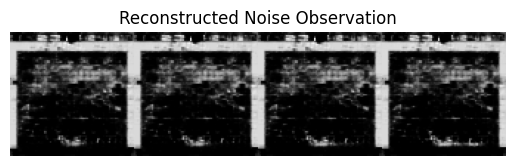

In [63]:
# reconstruct observations
noise = torch.randn((1, encoded_features_train[0].shape[0])).to(device)
reconstructed_images = decoder(noise)
display_obs(reconstructed_images, 'Reconstructed Noise Observation')

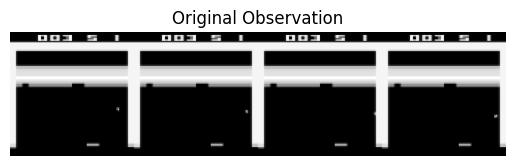

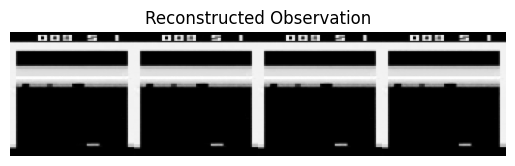

In [64]:
image = test_obs[0].unsqueeze(0)
encoded = probe_network.forward_features(image)
reconstructed_images = decoder(encoded)
display_obs(image, 'Original Observation')
display_obs(reconstructed_images, 'Reconstructed Observation')

### Concept backprop with decoder

In [65]:
# same code, but loss2 calculation and perturbation is different
# have to calculate probe values differently

pertubation_lr = 0.01
iterations = 1000
loss_ratio = 1000

# get shape of encoded features
acts_dummy = probe_network.forward_features(test_obs[0].unsqueeze(0))
perturbation = torch.zeros_like(acts_dummy, requires_grad=True).to(device)

initial_prediction = probe_network.forward_probe(probe_network.forward_features(example_obs) + perturbation)
print(f"Initial Prediction: {initial_prediction}")

for i in range(iterations):
    features = probe_network.forward_features(example_obs) + perturbation
    concept_value_pred = probe_network.forward_probe(features)
    decoded = decoder(features)
    loss1 = torch.norm(concept_value_pred - target_concept_value, p=1)
    loss2 = torch.norm(decoded - example_obs, p=2)
    total_loss = loss_ratio * loss1 + loss2

    if i % 100 == 0:
        print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    total_loss.backward()

    # update perturbation
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()

final_prediction = probe_network.forward_probe(probe_network.forward_features(example_obs) + perturbation)
print(f"Final Prediction: {final_prediction}")

Initial Prediction: tensor([[0.8707]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Iteration   0 - Loss1: 0.8707, Loss2: 568.8887, Total Loss: 1439.5554
Iteration 100 - Loss1: 0.0013, Loss2: 484.2446, Total Loss: 485.5304
Iteration 200 - Loss1: 0.0007, Loss2: 484.8954, Total Loss: 485.5907
Iteration 300 - Loss1: 0.0005, Loss2: 481.3810, Total Loss: 481.8850
Iteration 400 - Loss1: 0.0004, Loss2: 479.1473, Total Loss: 479.5334
Iteration 500 - Loss1: 0.0003, Loss2: 477.8391, Total Loss: 478.1598
Iteration 600 - Loss1: 0.0003, Loss2: 476.2755, Total Loss: 476.5558
Iteration 700 - Loss1: 0.0002, Loss2: 475.4462, Total Loss: 475.6957
Iteration 800 - Loss1: 0.0002, Loss2: 474.9836, Total Loss: 475.2094
Iteration 900 - Loss1: 0.0002, Loss2: 474.6149, Total Loss: 474.8220
Final Prediction: tensor([[0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)


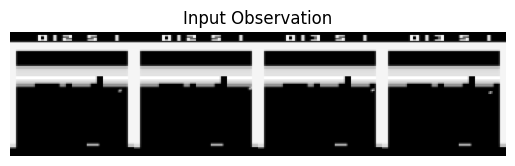

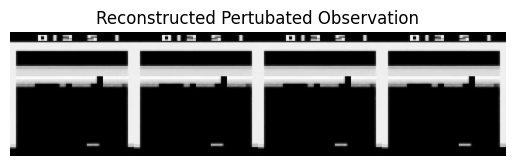

In [66]:
display_obs(example_obs, 'Input Observation')
decoded = decoder(probe_network.forward_features(example_obs) + perturbation)
display_obs(decoded, 'Reconstructed Pertubated Observation')